# NoSQL (Neo4j) (sesión 7)

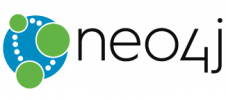

Esta hoja muestra cómo acceder a bases de datos Neo4j y también a conectar la salida con Google Colab/Jupyter.


[Neo4j Sandbox, https://neo4j.com/sandbox](https://neo4j.com/sandbox)

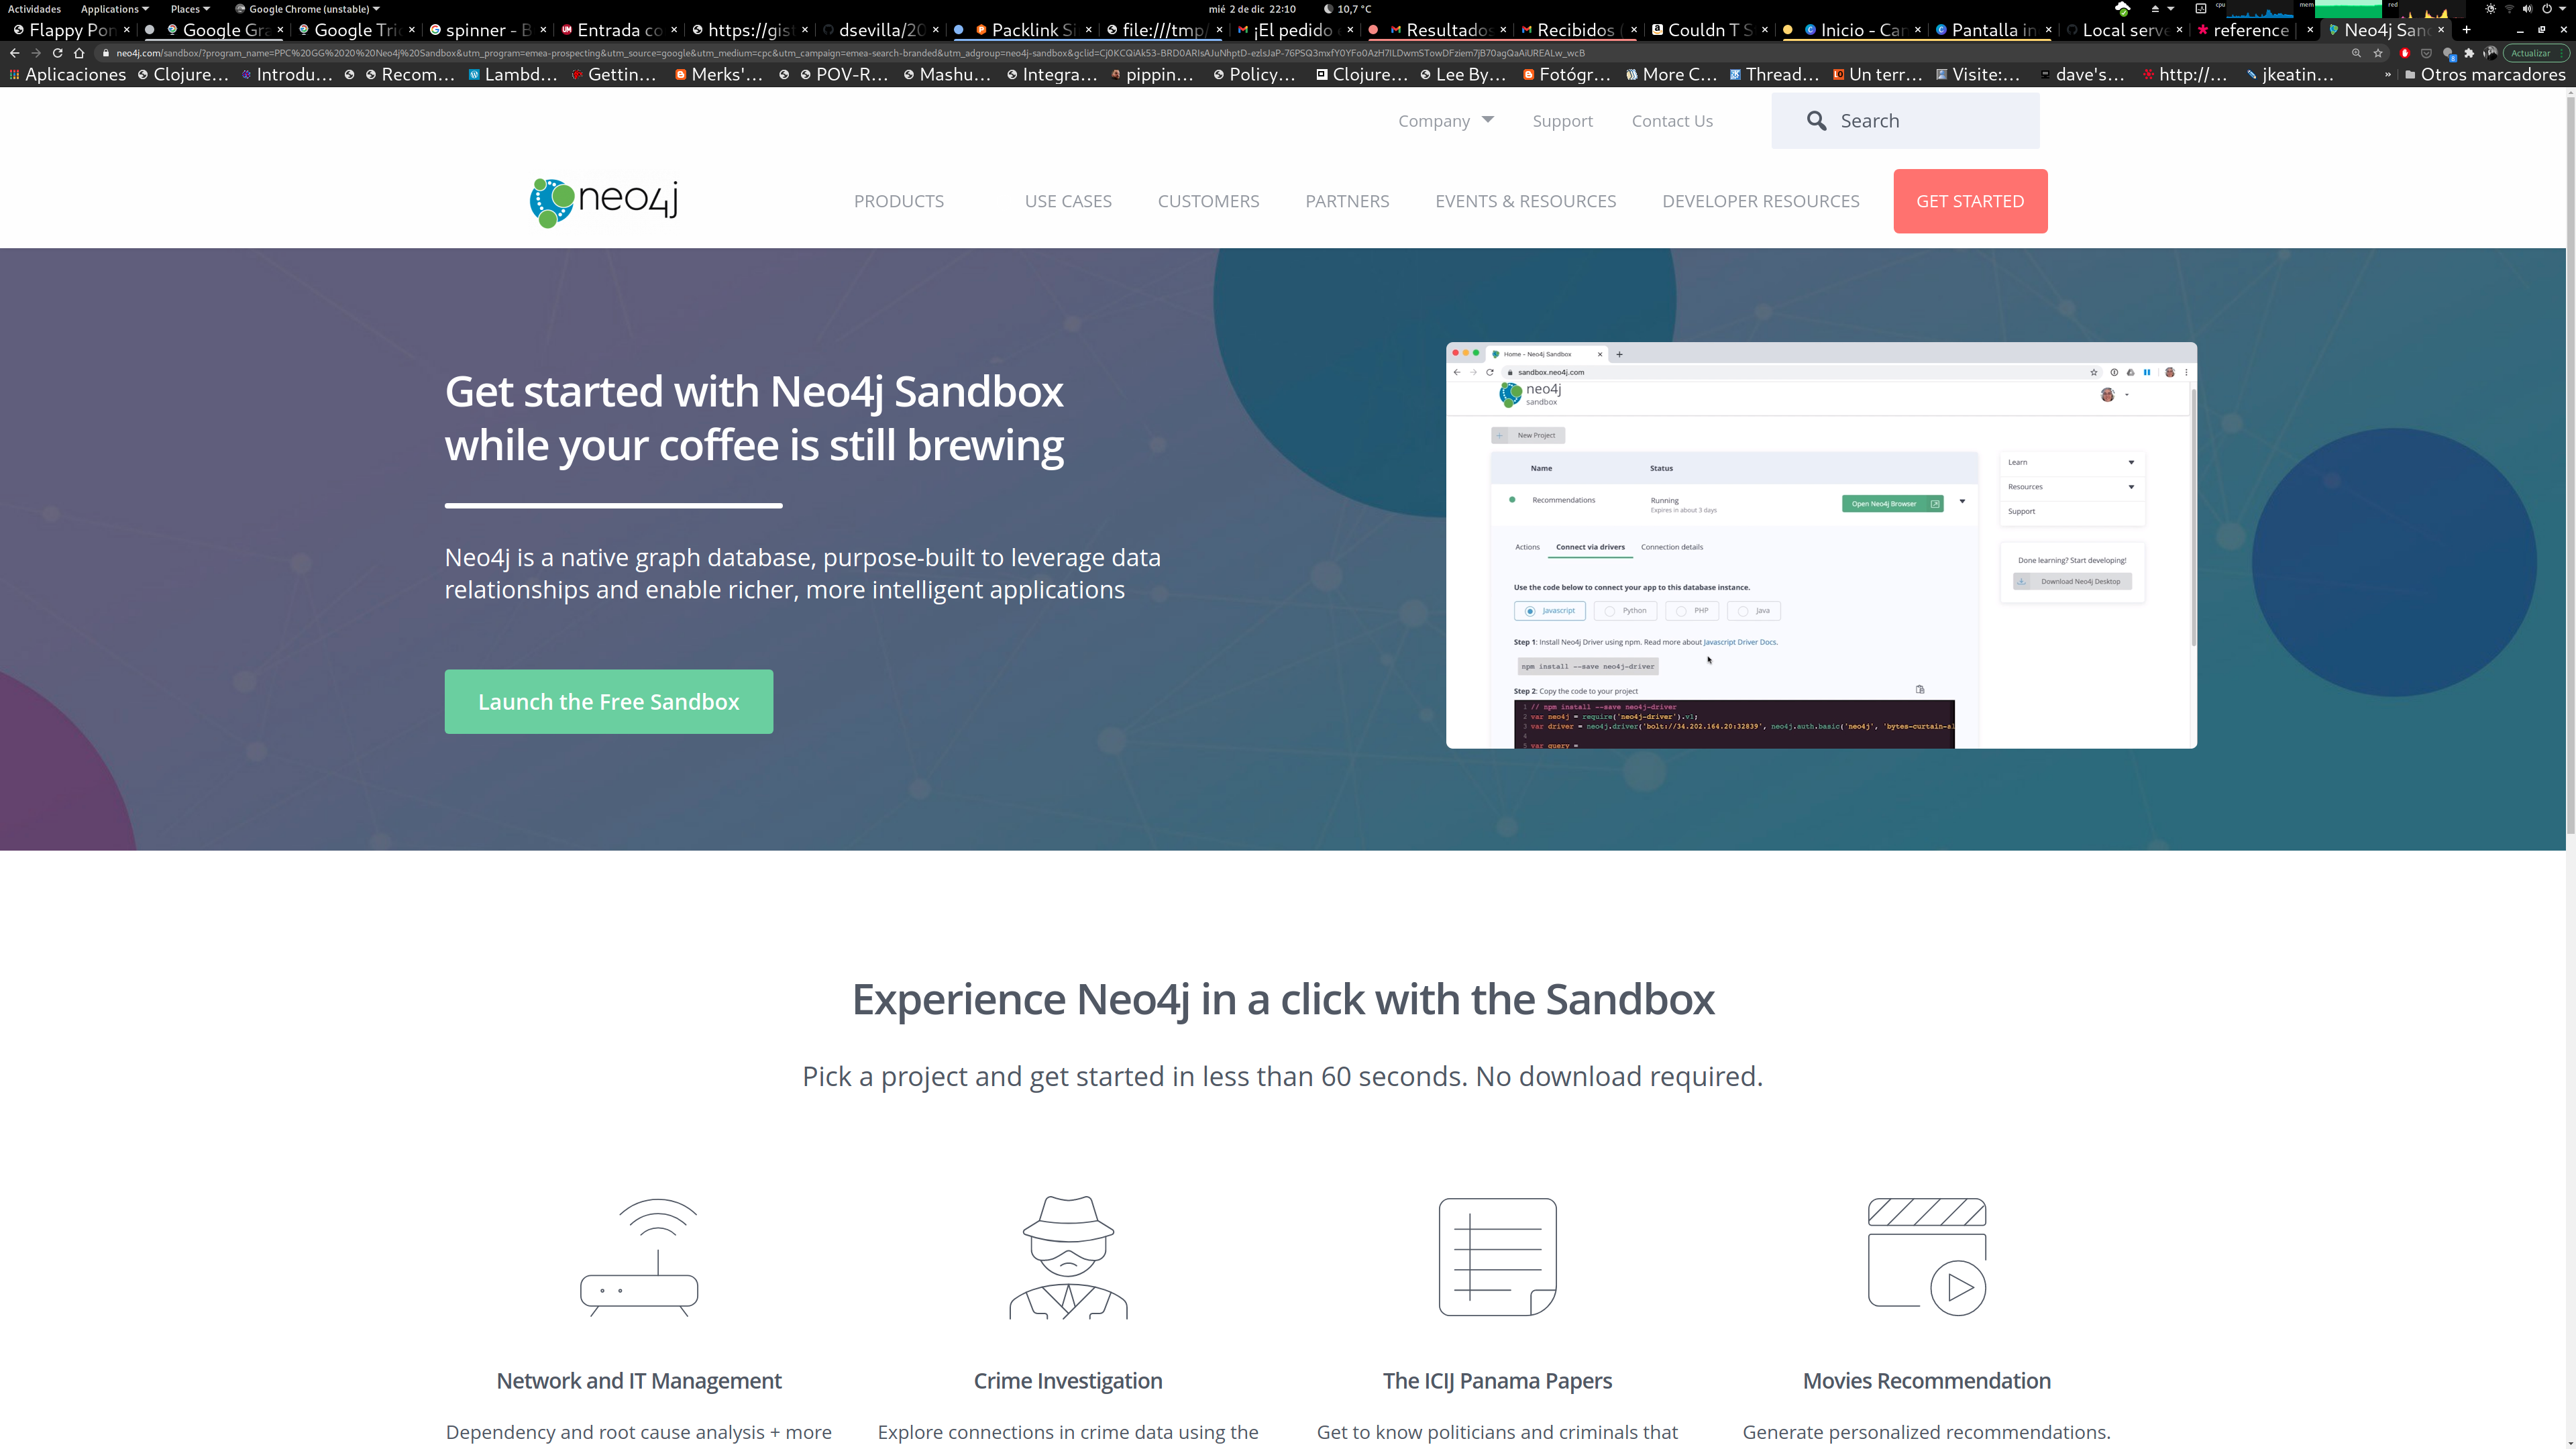

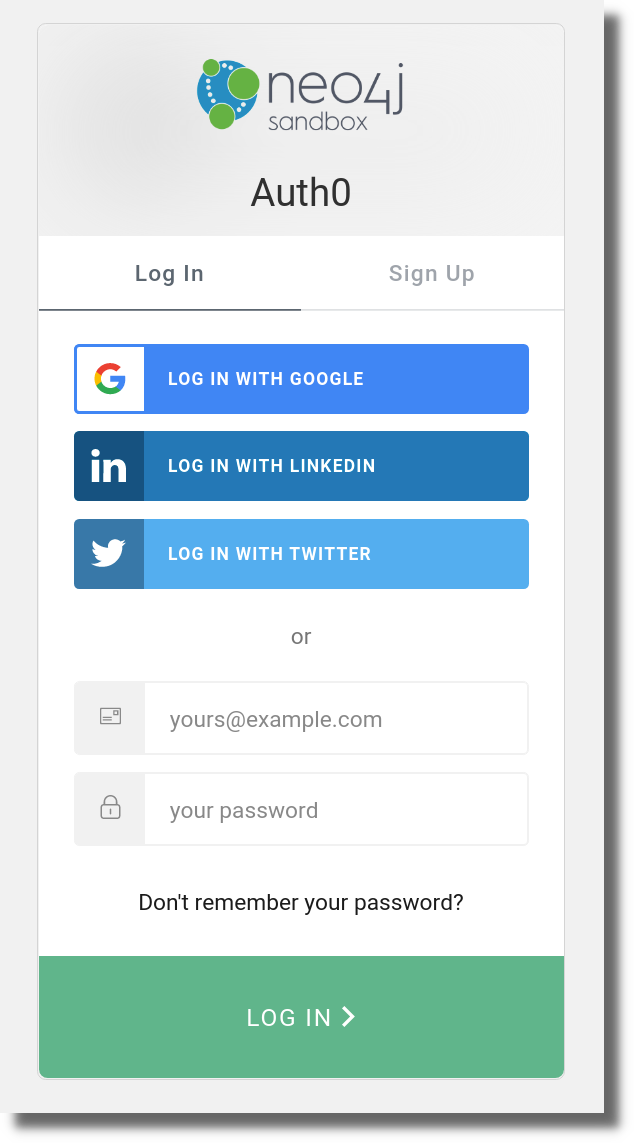

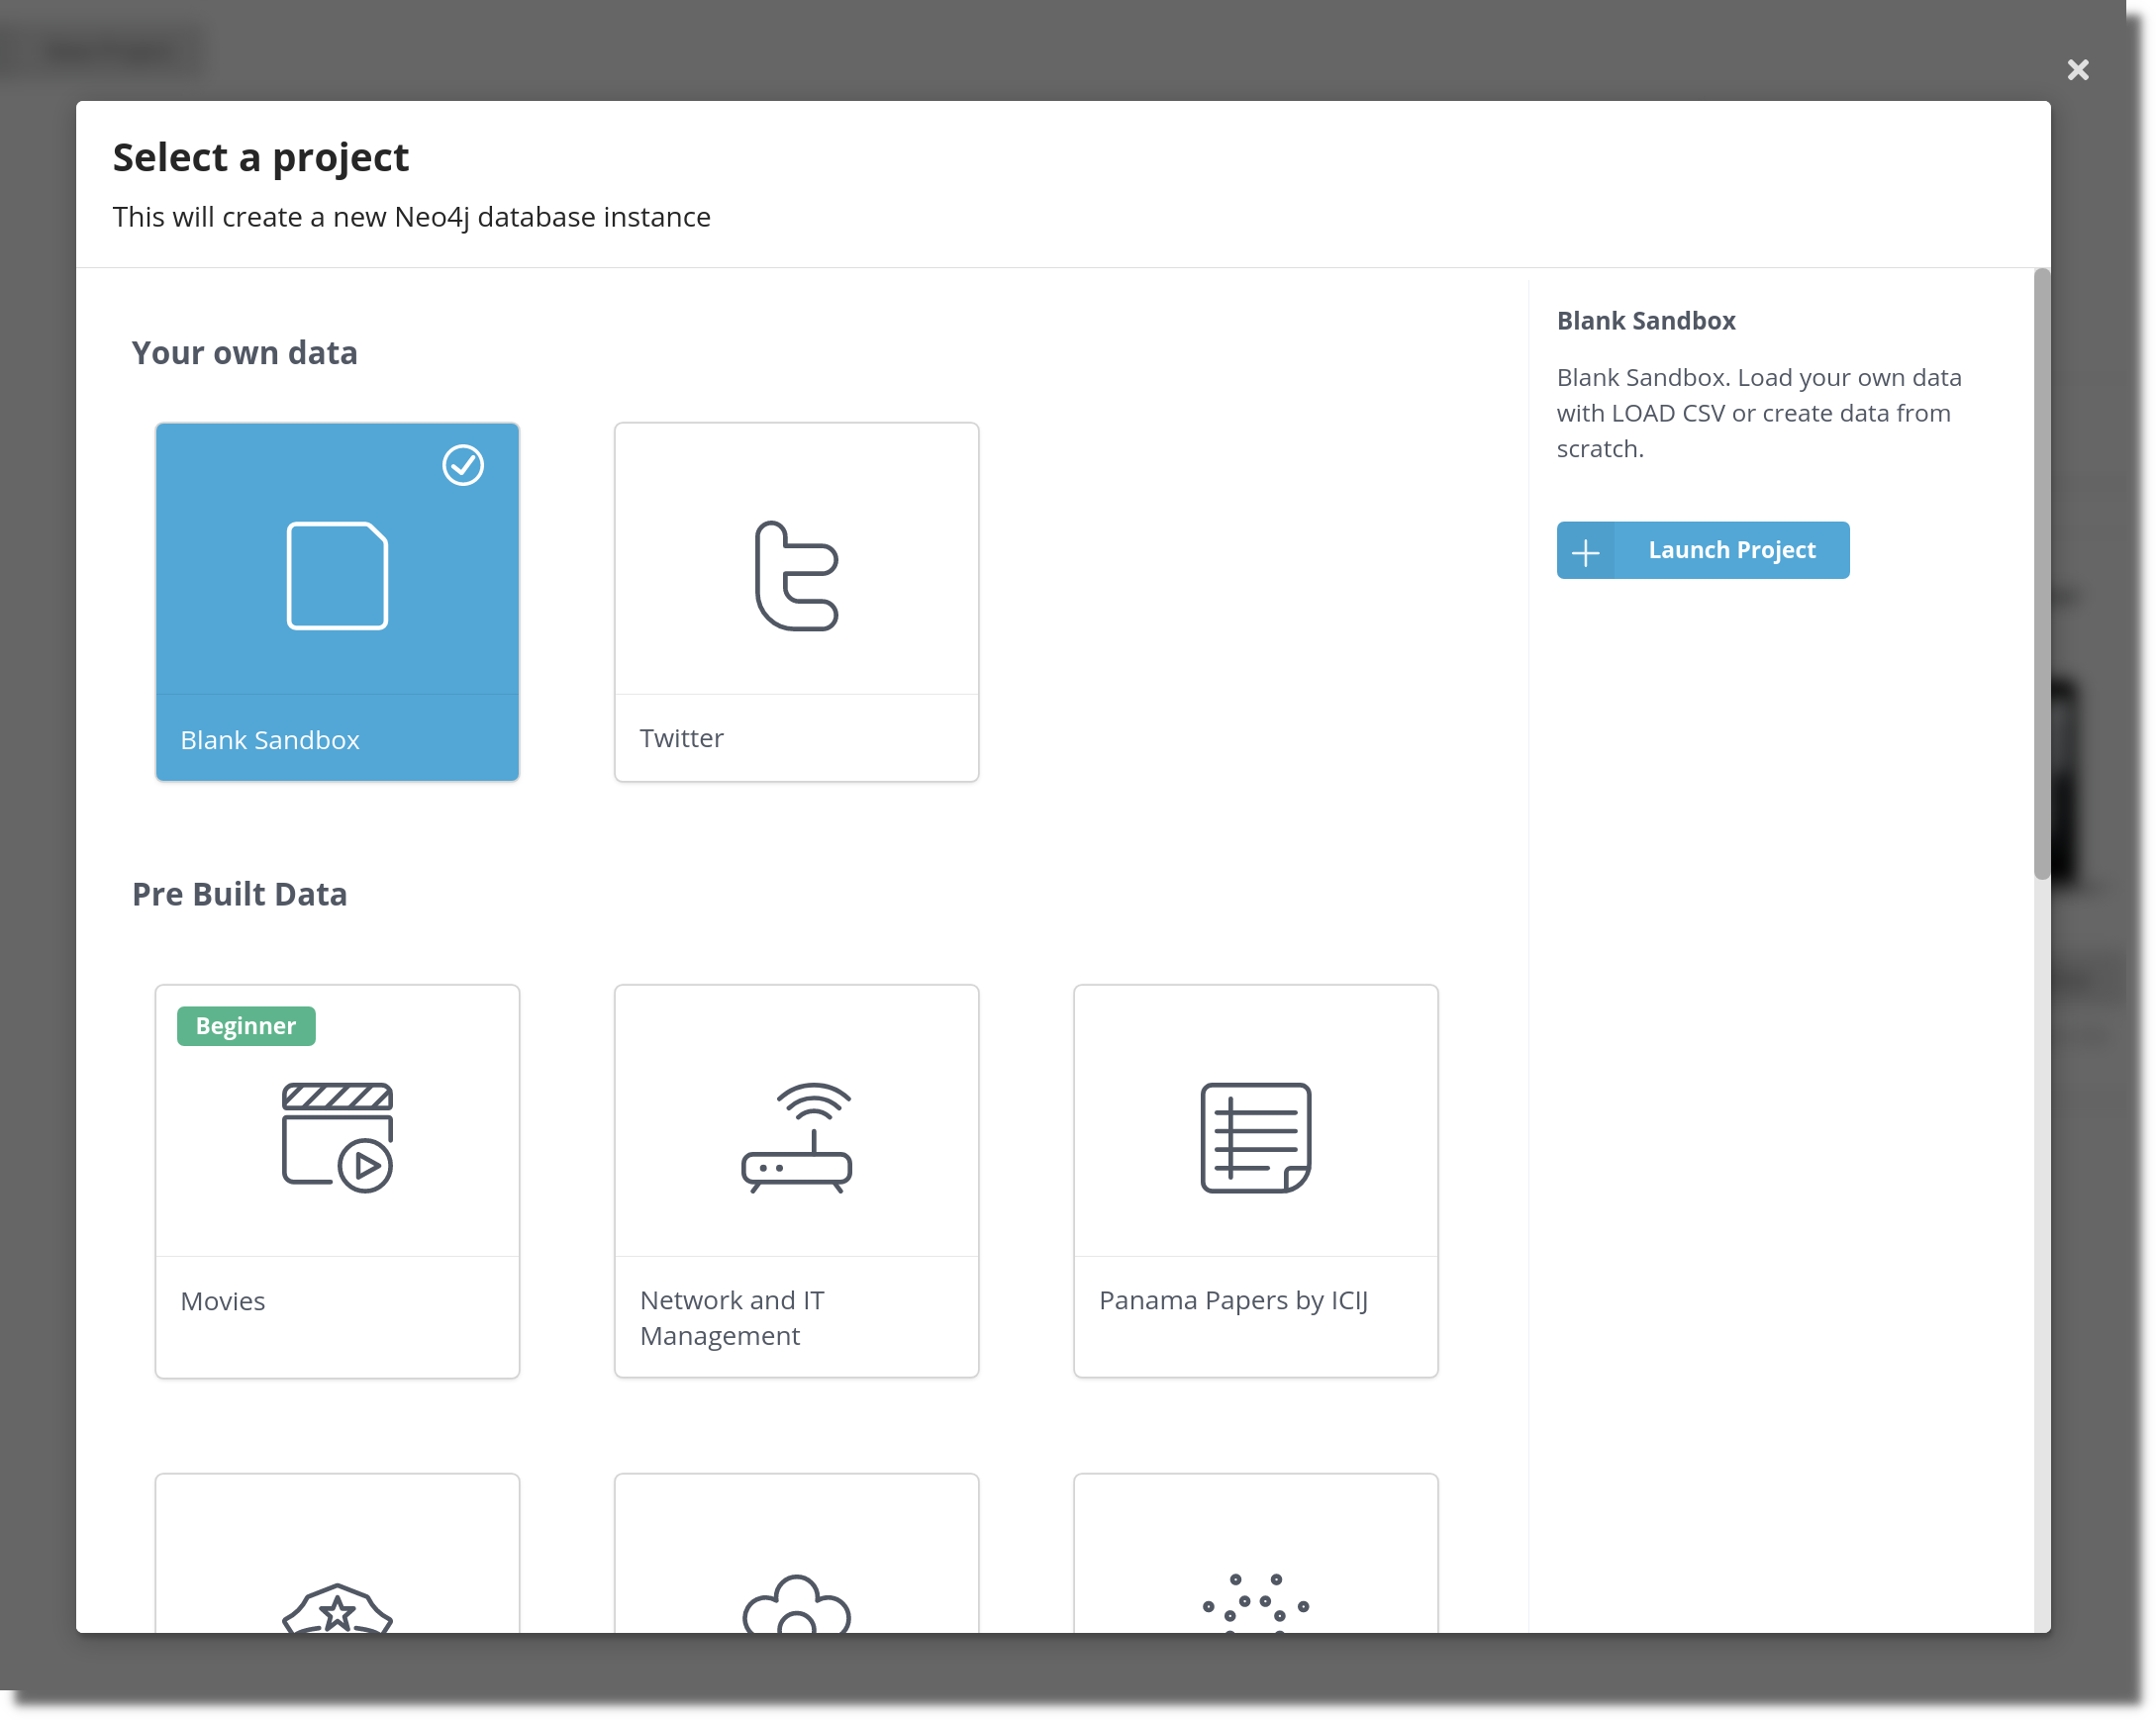

In [ ]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [ ]:
!pip install neo4j-driver

Conexión a la Base de Datos


In [ ]:
from neo4j import GraphDatabase
client = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "neo4j"))
with client.session() as session:
  print()

La siguiente celda genera una consulta en Cypher que devuelve los 10 primeros nodos. Al inicio la base de datos está vacía, pero se puede probar después para ver la salida. Existen plugins para ver gráficamente la salida como un grafo, pero para eso usaremos el interfaz gráfico del propio Neo4j.

In [ ]:
%%cypher
match (n) return n limit 10;

La carga de datos CSV no se podía realizar directamente desde los ficheros CSV la hoja, porque el CSV que acepta Neo4j no es estándar. Envié un *issue* para que lo arreglaran, y en la versión 3.3 parece que ya funciona si se añade un parámetro de configuración: https://github.com/neo4j/neo4j/issues/8472

```bash
dbms.import.csv.legacy_quote_escaping = false
```

He añadido al contenedor de la práctica esta opción en la carga de Neo4j. Tened en cuenta que si usáis otra configuración hay que añadírselo.

Primero se crea un índice sobre el atributo `Id` de `User`, que se usará después para crear usuarios y relacionarlos con la pregunta o respuesta que se ha leído. Si no se hace esto, la carga del CSV es muy lenta.

In [ ]:
%%cypher
CREATE INDEX ON :User(Id);

El siguiente código carga el CSV de las preguntas y respuestas. El código primero todos los nodos con la etiqueta `Post`, y después añade la etiqueta `Question` ó `Answer` dependiendo del valor del atributo `PostTypeId`.

In [ ]:
%%cypher
USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "http://neuromancer.inf.um.es:8080/es.stackoverflow/Posts.csv" AS row
    CREATE (n)
    SET n=row
    SET n :Post
    ;

A todas las preguntas, se las etiqueta con `Question`.

In [ ]:
%%cypher
MATCH (n:Post {PostTypeId : "1"})
  SET n:Question;

A todas las respuestas se las etiqueta con `Answer`.

In [ ]:
%%cypher
MATCH (n:Post {PostTypeId : "2"})
  SET n:Answer;

Se crea un nodo usuario (o se utiliza uno si ya existe) usando el campo `OwnerUserId`, siempre que no esté vacío. Nótese que se puede utilizar `CREATE` porque esta combinación de relación usuario y pregunta no existe. Cuidado, si se ejecuta dos veces creará el doble de relaciones.

In [ ]:
%%cypher
MATCH (n:Post)
WHERE n.OwnerUserId <> ""
    MERGE (u:User {Id: n.OwnerUserId})
    CREATE (u)-[:WROTE]->(n);

### El lenguaje Cypher

El lenguaje Cypher tiene una sintaxis de _Query By Example_. Acepta funciones y permite creación y búsqueda de nodos y relaciones. Tiene algunas peculiaridades que veremos a continuación. Por lo pronto, se puede ver un resumen de características en la [Cypher Reference Card](https://neo4j.com/docs/cypher-refcard/current/).

La anterior consulta utiliza la construcción `LOAD CSV` para leer datos CSV dentro de nodos. La cláusula `CREATE` crea nuevos nodos. La `SET` permite poner valores a las propiedades de los nodos.

En el caso de la consulta de arriba, a todos los datos leídos se les copia los datos de la línea (primer `SET`). Después, dependiendo del valor de `PostTypeId`, se les etiqueta como `:Question` o como `:Answer`. Si tienen un usuario asignado a través de `OwnerUserId`, se añade un usuario si no existe y se crea la relación `:WROTE`.

También hay otros posts especiales que no eran preguntas ni respuestas. A estos no se les asigna una segunda etiqueta:

In [ ]:
%%cypher
match (n:Post) WHERE size(labels(n)) = 1 RETURN n;

Creamos un índice sobre el `Id` para acelerar las siguientes búsquedas:

In [ ]:
%%cypher
CREATE INDEX ON :Post(Id);

Añadimos una relación entre las preguntas y las respuestas:

In [ ]:
%%cypher
MATCH (a:Answer), (q:Question {Id: a.ParentId})
CREATE (a)-[:ANSWERS]->(q)
;

Las construcciones `%cypher` retornan resultados de los que se puede obtener un `dataframe` de `pandas`:

In [ ]:
#%%cypher
res = %cypher MATCH q=(r)-[:ANSWERS]->(p) RETURN p.Id,r.Id;
df = res.get_dataframe()
df['r.Id'] = pd.to_numeric(df['r.Id'],downcast='unsigned')
df['p.Id'] = pd.to_numeric(df['p.Id'],downcast='unsigned')

df.plot(kind='scatter',x='p.Id',y='r.Id',figsize=(15,15))

La consulta RQ4 se puede resolver de manera muy fácil. En esta primera consulta se devuelve los nodos:

In [ ]:
%%cypher
// RQ4
MATCH
(u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
(u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND u1.Id < u2.Id
RETURN DISTINCT u1,u2
;

O bien retornar los `Id` de cada usuario:

In [ ]:
%%cypher
MATCH
(u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
(u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND toInt(u1.Id) < toInt(u2.Id)
RETURN DISTINCT u1.Id,u2.Id
ORDER BY toInt(u1.Id)
;

Y finalmente, la creación de relaciones `:RECIPROCATE` entre los usuarios. Se introduce también la construcción `WITH`.

`WITH` sirve para introducir "espacios de nombres". Permite importar nombres de filas anteriores, hacer alias con `AS` e introducir nuevos valores con funciones de Cypher. La siguiente consulta es la misma de arriba, RQ4, pero creando relaciones `:RECIPROCATE` entre cada dos usuarios que se ayudan recíprocamente.

In [ ]:
%%cypher
// RQ4 creando relaciones de reciprocidad
MATCH
  (u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User),
  (u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND u1.Id < u2.Id
WITH u1 AS user1,u2 AS user2
  MERGE (user1)-[:RECIPROCATE]->(user2)
  MERGE (user2)-[:RECIPROCATE]->(user1)
;

También se puede buscar el camino mínimo entre dos usuarios cualesquiera. Si existe un camino a través de alguna pregunta o respuesta, la encontrará. Un ejemplo donde hay una comunicación directa:

In [ ]:
%%cypher
MATCH p=shortestPath( (u1:User {Id: '24'})-[*]-(u2:User {Id:'25'}) ) RETURN p

Mientras que con otro usuario la cadena es más larga:

In [ ]:
%%cypher
MATCH p=shortestPath( (u1:User {Id: '324'})-[*]-(u2:User {Id:'25'}) ) RETURN p

Finalmente se pueden encontrar todos los caminos mínimos en donde se ve que tiene que existir al menos un par pregunta/respuesta entre los usuarios que son recíprocos:

In [ ]:
%%cypher
MATCH p=allShortestPaths( (u1:User {Id: '24'})-[*]-(u2:User {Id:'25'}) ) RETURN p

## EJERCICIO: Construir los nodos `:Tag` para cada uno de los tags que aparecen en las preguntas. Construir las relaciones `post-[:TAGGED_BY]->tag` para cada tag y también `tag-[:TAGS]->post`

Para ello, buscar en la ayuda las construcciones `WITH` y `UNWIND` y las funciones `replace()` y `split()` de Cypher. La siguiente consulta debe retornar 5703 resultados:

In [ ]:
%%cypher
MATCH p=(t:Tag)-[:TAGS]->(:Question) WHERE t.name =~ "^java$|^c\\+\\+$" RETURN count(p);

La siguiente consulta muestra los usuarios que preguntan por cada Tag:

In [ ]:
%%cypher
MATCH (t:Tag)-->(:Question)<--(u:User) RETURN t.name,collect(distinct u.Id) ORDER BY t.name;

El mismo `MATCH` se puede usar para encontrar qué conjunto de tags ha usado cada usuario cambiando lo que retornamos:

In [ ]:
%%cypher
MATCH (t:Tag)-->(:Question)<--(u:User) RETURN u.Id, collect(distinct t.name) ORDER BY toInt(u.Id);

## EJERCICIO: Relacionar cada usuario con los tags de sus preguntas a través de la relación `:INTERESTED_IN` (similar a E1).

## EJERCICIO: Cargar el CSV de Users y añadir las propiedades faltantes a los usuarios (hasta ahora cada nodo `:User` sólo tiene la propiedad `Id`. Hay que cargar el resto a partir del CSV).

## EJERCICIO: Cargar el CSV de Comments y conectarlos con los Posts.

## EJERCICIO: Recomendar a los usuarios _tags_ sobre los que podrían estar interesados en base a _tags_ en los que los usuarios con los que están relacionados con `:RECIPROCATE` están interesados y ellos no, ordenado por número de usuarios interesados en cada _tag_.